# ESG Pre-filter Classifier - EDA & Feature Engineering

This notebook focuses on exploratory data analysis and feature engineering for the ESG pre-filter classifier. It compares multiple feature engineering approaches and exports the best transformer for use in model selection.

## Objective
Develop feature engineering pipeline that can distinguish between articles that contain ESG (Environmental, Social, Governance) content vs those that don't.

**Key Insight: This is a recall-focused problem.**
- **Missing an ESG article (low recall) = BAD** - we miss content that should be labeled
- **Letting through a non-ESG article (low precision) = OK** - LLM can skip it later

We optimize for **F2 score** which weights recall 2x higher than precision.

## Contents
1. [Setup](#setup)
2. [Data Loading](#1-data-loading)
3. [Target Variable Analysis](#2-target-variable-analysis) (ALL DATA - for stratification)
4. [Data Preprocessing & Split](#3-data-preprocessing--split)
5. [Exploratory Data Analysis](#4-exploratory-data-analysis) (TRAINING DATA ONLY)
6. [Feature Engineering Comparison](#5-feature-engineering-comparison)
   - 5.1 [Feature Transformer Hyperparameter Tuning](#51-feature-transformer-hyperparameter-tuning)
7. [Pipeline Export](#6-pipeline-export)
8. [Summary](#7-summary)

## Target Brands (50)

The system monitors news for the following sportswear and outdoor apparel brands:

| | | | | |
|-------|-------|-------|-------|-------|
| Nike | Adidas | Puma | Under Armour | Lululemon |
| Patagonia | Columbia Sportswear | New Balance | ASICS | Reebok |
| Skechers | Fila | The North Face | Vans | Converse |
| Salomon | Mammut | Umbro | Anta | Li-Ning |
| Brooks Running | Decathlon | Deckers | Yonex | Mizuno |
| K-Swiss | Altra Running | Hoka | Saucony | Merrell |
| Timberland | Spyder | On Running | Allbirds | Gymshark |
| Everlast | Arc'teryx | Jack Wolfskin | Athleta | Vuori |
| Cotopaxi | Prana | Eddie Bauer | 361 Degrees | Xtep |
| Peak Sport | Mountain Hardwear | Black Diamond | Outdoor Voices | Diadora |

See `src/data_collection/config.py` for the authoritative brand list.

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import LinearSVC

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.ep1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    split_train_val_test,
)
from src.ep1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.ep1_nb.preprocessing import (
    clean_text,
    create_text_features,
)
from src.ep1_nb.feature_transformer import EPFeatureTransformer
from src.ep1_nb.modeling import (
    analyze_tuning_results,
    plot_fe_comparison,
    plot_tuning_results,
    tune_feature_transformer,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
TARGET_COL = 'has_esg'
LABEL_NAMES = ['No ESG', 'Has ESG']
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.6, 0.2, 0.2
RANDOM_STATE = 42
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'ep_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading

In [2]:
# Load the ESG pre-filter training data
df = load_jsonl_data(DATA_PATH)

Loaded 939 records from ep_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'has_esg', 'source', 'skip_reason']
Memory usage: 6.49 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,source_name,category,has_esg,source,skip_reason
0,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],insideretail.asia,[],1,labeled,NaN
1,c1a8b5eb-fa19-409b-84b2-7fe42af406cf,"I cant think of a place more pristine : 133 , 000 hectares of Chilean Patagonia preserved afte...",A wild valley in Chilean Patagonia has been preserved for future generations and protected from ...,[Patagonia],theguardian.com,[],1,labeled,NaN
2,c10de7db-ddd3-4f2c-b6bb-9704be93649d,Adidas Unveils New Mohamed Salah F50 Elite Boots Ahead of AFCON,"Adidas just dropped a new signature F50 Elite colourway for Mohamed Salah, created in collaborat...",[Adidas],cairoscene.com,[],1,labeled,NaN
3,135068ac-2ef6-4e80-b217-0cc69c74e571,Nike China conundrum deepens as turnaround stagnates – Channel Africa,"The United States (US) sportswear giant’s sixth straight quarterly sales decline in the country,...",[Nike],channelafrica.co.za,[],1,labeled,NaN
4,9c1dd668-5fbe-4a2e-b4bc-069b815124c3,Does Lululemon Accept Returns Nationwide ?,A customer went inside a Lululemon store to exchange some leggings she purchased in Louisiana. T...,[Lululemon],themarysue.com,[],1,labeled,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   article_id   939 non-null    object
 1   title        939 non-null    object
 2   content      939 non-null    object
 3   brands       939 non-null    object
 4   source_name  939 non-null    object
 5   category     939 non-null    object
 6   has_esg      939 non-null    int64 
 7   source       939 non-null    object
 8   skip_reason  240 non-null    object
dtypes: int64(1), object(8)
memory usage: 66.2+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id       0
title            0
content          0
brands           0
source_name      0
category         0
has_esg          0
source           0
skip_reason    699
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled           530
skipped           240
labeled_no_esg    169
Name: count, dtype: int64


## 2. Target Variable Analysis (ALL DATA)

This analysis uses the full dataset to understand class imbalance before splitting. This is necessary to inform our stratification strategy.

TARGET VARIABLE ANALYSIS

Total samples: 939

Class distribution:
  No ESG: 409 (43.6%)
  Has ESG: 530 (56.4%)

Imbalance ratio: 1.30:1

[OK] Dataset is reasonably balanced
Figure saved to images/ep_target_distribution.png


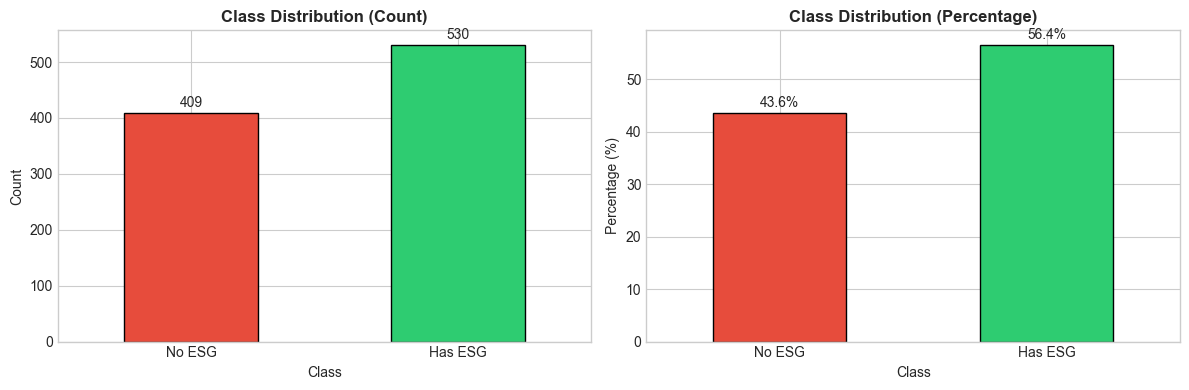

In [7]:
# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/ep_target_distribution.png'
)

## 3. Data Preprocessing & Train/Val/Test Split

We preprocess the text data first (creating text_features), then split into train/val/test sets. All subsequent EDA and feature engineering will use ONLY the training data to prevent data leakage. The validation dataset is used for feature engineering selection. The test data set is NOT used in this notebook.

In [8]:
# Create text features BEFORE splitting
# This combines title, brands, and content into a single cleaned text field
# Now includes source_name and category for metadata features
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"\nRecords with empty text features: {empty_texts}")
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records after removing empty: {len(df)}")

Text features created!
Sample:
insideretail.asia the factors behind lululemon ceo calvin mcdonald departure from the brand the factors behind lululemon ceo calvin mcdonald departure from the brand lululemon after seven years as ceo of athleisure giant lululemon retail veteran calvin mcdonald announced he would be leaving the comp...

Records with empty text features: 0


In [9]:
# Split with stratification
train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Extract features and targets
X_train = train_df['text_features']
y_train = train_df[TARGET_COL]

X_val = val_df['text_features']
y_val = val_df[TARGET_COL]

# Extract metadata for discrete metadata features
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()
val_source_names = val_df['source_name'].tolist()
val_categories = val_df['category'].tolist()

# Combine train+val for feature engineering comparison and tuning
# CV will create its own internal train/val splits, so we use 80% of data
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = np.concatenate([y_train, y_val])
trainval_source_names = train_source_names + val_source_names
trainval_categories = train_categories + val_categories

print(f"\nDataset sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")
print(f"  Train+Val (for CV): {len(X_trainval)} samples")

TRAIN/VALIDATION/TEST SPLIT

Total samples: 939

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      563 (60.0%)
  Validation: 188 (20.0%)
  Test:       188 (20.0%)

Class distribution (stratified by 'has_esg'):
  Train: 1: 56.5%, 0: 43.5%
  Val: 1: 56.4%, 0: 43.6%
  Test: 1: 56.4%, 0: 43.6%

Dataset sizes:
  Train: 563 samples
  Val:   188 samples
  Train+Val (for CV): 751 samples


## 4. Exploratory Data Analysis (TRAINING DATA ONLY)

All EDA from this point forward uses ONLY the training data to prevent data leakage.

### 4.1 Text Length Analysis

In [10]:
# Analyze text lengths (TRAINING DATA ONLY)
text_stats = analyze_text_length_stats(train_df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 563

Overall statistics:
  Character length: mean=3645, median=2490, range=[140, 52711]
  Word count: mean=592, median=406, range=[22, 8910]

By has_esg:
  Class 1:
    Chars: mean=4205, median=2962
    Words: mean=677, median=476
  Class 0:
    Chars: mean=2918, median=1905
    Words: mean=482, median=314


Figure saved to images/ep_text_length_dist.png


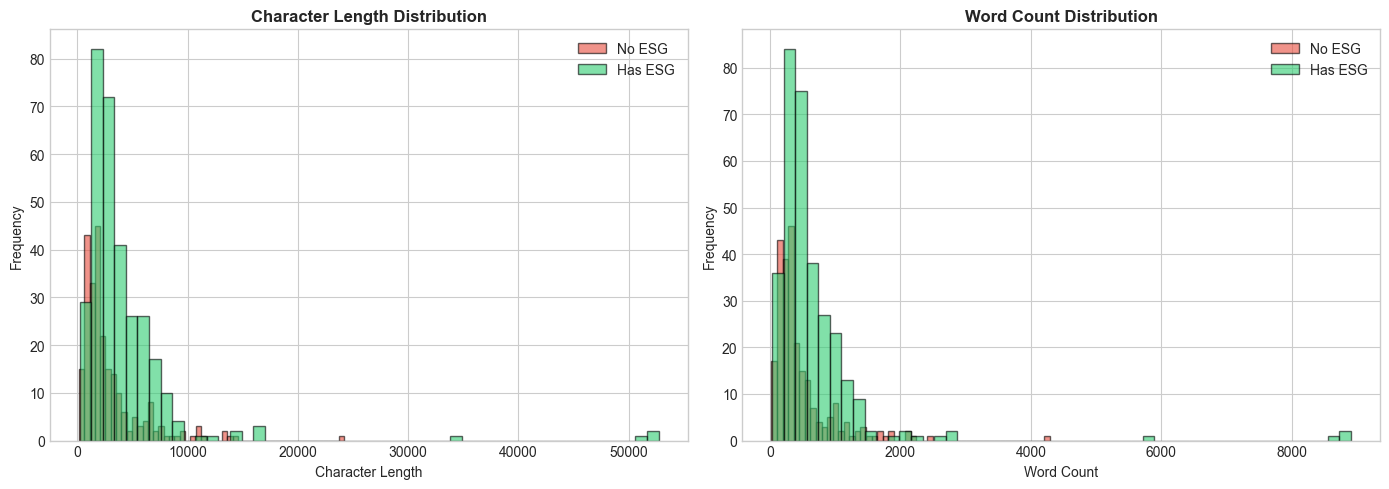

In [11]:
# Plot text length distributions by class (TRAINING DATA ONLY)
plot_text_length_distributions(
    train_df, 'content', TARGET_COL,
    label_names={0: 'No ESG', 1: 'Has ESG'},
    save_path='images/ep_text_length_dist.png'
)

### 4.2 Brand Distribution

In [12]:
# Analyze brand distribution (TRAINING DATA ONLY)
brand_counts = analyze_brand_distribution(train_df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 594
Unique brands: 37

Top 15 brands:
  Nike: 187 (31.5%)
  Lululemon: 79 (13.3%)
  Adidas: 41 (6.9%)
  Hoka: 31 (5.2%)
  Skechers: 23 (3.9%)
  Puma: 22 (3.7%)
  Patagonia: 20 (3.4%)
  New Balance: 19 (3.2%)
  Reebok: 17 (2.9%)
  Timberland: 15 (2.5%)
  The North Face: 13 (2.2%)
  ASICS: 13 (2.2%)
  Gymshark: 9 (1.5%)
  Salomon: 9 (1.5%)
  Deckers: 9 (1.5%)

Brand distribution by has_esg:
  Class 0: 256 mentions, top: Nike (69), Hoka (27), Lululemon (24)
  Class 1: 338 mentions, top: Nike (118), Lululemon (55), Adidas (21)


Figure saved to images/ep_brand_dist.png


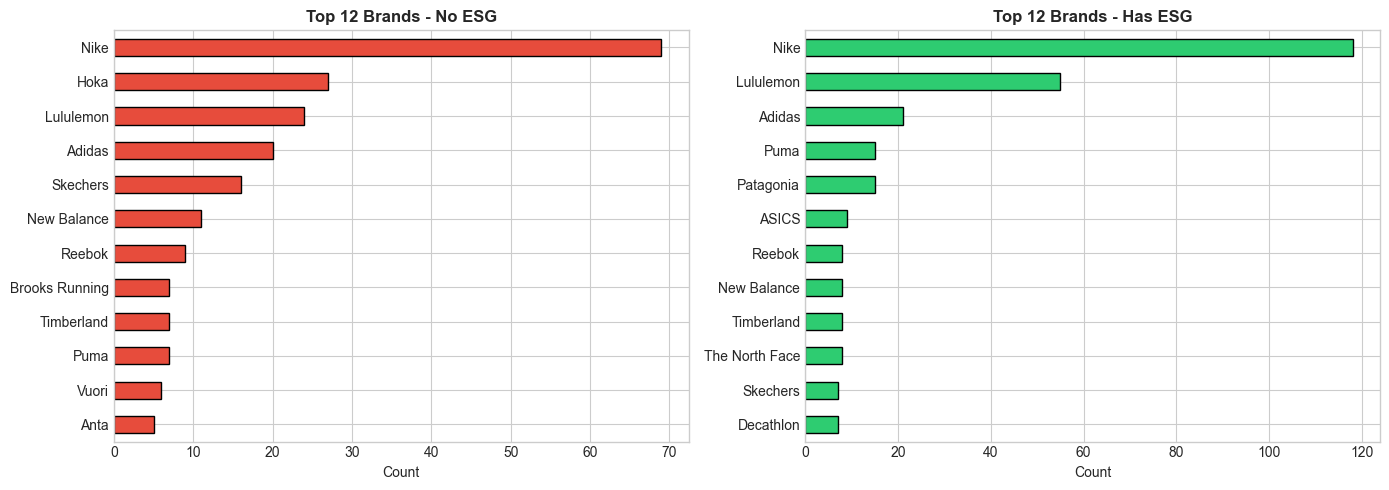

In [13]:
# Plot brand distribution by class (TRAINING DATA ONLY)
plot_brand_distribution(
    train_df, 'brands', TARGET_COL,
    label_names={0: 'No ESG', 1: 'Has ESG'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/ep_brand_dist.png'
)

### 4.3 Word Frequency Analysis

In [14]:
# Analyze word frequencies by class (TRAINING DATA ONLY)
word_freqs = analyze_word_frequencies(train_df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  nike: 358
  off: 322
  shoes: 309
  sale: 304
  shoe: 300
  amazon: 300
  out: 281
  running: 264
  deals: 262
  women: 253
  best: 249
  hoka: 234
  read: 230
  sneakers: 220
  less: 219

Top 15 words for class_1:
  nike: 1,357
  company: 913
  year: 796
  brand: 654
  quarter: 619
  lululemon: 574
  stock: 555
  shares: 520
  growth: 451
  over: 383
  market: 382
  like: 372
  down: 349
  running: 345
  billion: 344


In [15]:
# Look at some non-ESG examples (TRAINING DATA ONLY)
print("\n" + "="*60)
print("SAMPLE NON-ESG ARTICLES (from training data)")
print("="*60)

no_esg_train = train_df[train_df[TARGET_COL] == 0]
if len(no_esg_train) >= 3:
    samples = no_esg_train.sample(3, random_state=RANDOM_STATE)
else:
    samples = no_esg_train

for _, row in samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'skip_reason' in row and pd.notna(row['skip_reason']):
        print(f"Skip Reason: {row['skip_reason']}")
    print("-" * 40)


SAMPLE NON-ESG ARTICLES (from training data)

Brands: ['New Balance']
Title: New Balance’s Sleek New 2010 Sneaker Gets a Classy Collaboration With Rich Paul...
----------------------------------------

Brands: ['Vuori']
Title: Vuori End - of - Year Sale Includes Black Friday - Level Prices...
----------------------------------------

Brands: ['Timberland']
Title: Louis Vuitton and Timberland Release $85K Limited Edition Luxury Boot | 96 . 3 KISS - FM...
----------------------------------------


## 5. Feature Engineering Comparison

We compare multiple feature engineering approaches using cross-validation on the combined training+validation data (80% of total). Since cross-validation creates its own internal train/val splits, using the full train+val set provides more data for reliable hyperparameter selection while keeping the test set completely held out.

We benchmark with three classifiers: Logistic Regression, LinearSVM, Random Forest, and HistGradientBoosting. This helps us select the best feature engineering approach before moving to model selection in the next notebook.

In [ ]:
# Define feature engineering approaches to compare
fe_configs = {
    'tfidf_lsa': {
        'method': 'tfidf_lsa',
        'max_features': 10000,
        'lsa_n_components': 100,
        'include_metadata_features': False,
    },
    'tfidf_lsa_ner_proximity': {
        'method': 'tfidf_lsa_ner_proximity',
        'max_features': 10000,
        'lsa_n_components': 100,
        'proximity_window_size': 15,
        'include_metadata_features': False,
    },
    'tfidf_lsa_product': {
        'method': 'tfidf_lsa_product',
        'max_features': 10000,
        'lsa_n_components': 100,
        'proximity_window_size': 15,
        'include_metadata_features': False,
    },
    # 'sentence_transformer': {
    #     'method': 'sentence_transformer',
    #     'sentence_model_name': 'all-MiniLM-L6-v2',
    #     'include_metadata_features': False,
    # },
    'sentence_transformer_ner': {
        'method': 'sentence_transformer_ner',
        'sentence_model_name': 'all-MiniLM-L6-v2',
        'include_metadata_features': False,
    },
    'sentence_transformer_ner_vocab': {
        'method': 'sentence_transformer_ner_vocab',
        'sentence_model_name': 'all-MiniLM-L6-v2',
        'include_metadata_features': False,
    },
}

# Hyperparameter tuning configurations for each method
TUNING_CONFIGS = {
    'tfidf_lsa': {
        'param_name': 'lsa_n_components',
        'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400],
        'description': 'LSA dimensionality'
    },
    'tfidf_lsa_ner_proximity': {
        'param_name': 'lsa_n_components',
        'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400],
        'description': 'LSA dimensionality (with NER + proximity)'
    },
    'tfidf_lsa_product': {
        'param_name': 'lsa_n_components',
        'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400],
        'description': 'LSA dimensionality (with product detection)'
    },
    'sentence_transformer_ner': {
        'param_name': 'proximity_window_size',
        'param_values': [10, 15, 20, 25, 30],
        'description': 'NER proximity window size'
    },
    'sentence_transformer_ner_vocab': {
        'param_name': 'proximity_window_size',
        'param_values': [10, 15, 20, 25, 30],
        'description': 'NER+vocab proximity window size'
    },
}

print("Feature Engineering Approaches to Compare:")
print("=" * 50)
for name, config in fe_configs.items():
    print(f"  {name}: {config['method']}")

print("\nTuning configurations defined for:")
for name in TUNING_CONFIGS:
    cfg = TUNING_CONFIGS[name]
    print(f"  {name}: {cfg['param_name']} = {cfg['param_values']}")

In [17]:
# Evaluate each feature engineering approach using cross-validation
# Transformer is fitted on TRAINING data only (to prevent data leakage)
# CV is performed on TRAIN+VAL combined (CV creates internal splits)
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Define classifiers to benchmark
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(
            max_iter=2000,
            class_weight=None,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ),
        'requires_dense': False,
    },
    'LinearSVM': {
        'model': CalibratedClassifierCV(
            LinearSVC(max_iter=2000, random_state=RANDOM_STATE, class_weight=None),
            cv=3
        ),
        'requires_dense': False,
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            class_weight=None,
            n_jobs=-1
        ),
        'requires_dense': False,
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(
            max_iter=100,
            max_depth=5,
            class_weight=None,
            random_state=RANDOM_STATE,
        ),
        'requires_dense': True,
    },
}

fe_results = []

for name, config in fe_configs.items():
    print(f"Evaluating {name}...")
    
    # Create transformer
    transformer = EPFeatureTransformer(**config, random_state=RANDOM_STATE)
    
    # Fit transformer on TRAINING data only (to prevent data leakage)
    transformer.fit_transform(X_train)
    
    # Transform train+val data for CV evaluation
    X_trainval_fe = transformer.transform(X_trainval)
    
    print(f"  Feature shape: {X_trainval_fe.shape}, sparse: {sparse.issparse(X_trainval_fe)}")
    
    # Evaluate with each classifier
    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        
        # Convert to dense if classifier requires it
        if clf_info['requires_dense'] and sparse.issparse(X_trainval_fe):
            X_for_cv = X_trainval_fe.toarray()
        else:
            X_for_cv = X_trainval_fe
        
        # Cross-validation on train+val combined
        cv_scores = cross_validate(
            clf, X_for_cv, y_trainval,
            cv=cv,
            scoring={
                'f2': f2_scorer,
                'recall': 'recall',
                'precision': 'precision',
            },
            return_train_score=False
        )
        
        result = {
            'name': name,
            'classifier': clf_name,
            'n_features': X_trainval_fe.shape[1],
            'cv_f2': cv_scores['test_f2'].mean(),
            'cv_f2_std': cv_scores['test_f2'].std(),
            'cv_recall': cv_scores['test_recall'].mean(),
            'cv_precision': cv_scores['test_precision'].mean(),
        }
        fe_results.append(result)
        
        print(f"  [{clf_name}] CV F2: {result['cv_f2']:.4f} (+/- {result['cv_f2_std']:.4f})")

Evaluating tfidf_lsa...
  Feature shape: (751, 100), sparse: False
  [LogisticRegression] CV F2: 0.8323 (+/- 0.0225)
  [LinearSVM] CV F2: 0.8195 (+/- 0.0211)
  [RandomForest] CV F2: 0.8113 (+/- 0.0361)
  [HistGradientBoosting] CV F2: 0.8046 (+/- 0.0365)
Evaluating tfidf_lsa_ner_proximity...
  Feature shape: (751, 114), sparse: False
  [LogisticRegression] CV F2: 0.8039 (+/- 0.0352)
  [LinearSVM] CV F2: 0.8175 (+/- 0.0244)
  [RandomForest] CV F2: 0.8289 (+/- 0.0359)
  [HistGradientBoosting] CV F2: 0.8145 (+/- 0.0308)
Evaluating sentence_transformer_ner...
  Feature shape: (751, 390), sparse: False
  [LogisticRegression] CV F2: 0.8268 (+/- 0.0292)
  [LinearSVM] CV F2: 0.8259 (+/- 0.0146)
  [RandomForest] CV F2: 0.8261 (+/- 0.0249)
  [HistGradientBoosting] CV F2: 0.8025 (+/- 0.0112)
Evaluating sentence_transformer_ner_vocab...
  Feature shape: (751, 401), sparse: False
  [LogisticRegression] CV F2: 0.8170 (+/- 0.0316)
  [LinearSVM] CV F2: 0.8236 (+/- 0.0262)
  [RandomForest] CV F2: 0.8278

In [18]:
# Compare feature engineering results
fe_df = pd.DataFrame(fe_results)

# Create pivot table for easier comparison
pivot_df = fe_df.pivot_table(
    index='name',
    columns='classifier',
    values=['cv_f2', 'cv_recall', 'cv_precision'],
    aggfunc='first'
)

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPARISON RESULTS")
print("=" * 80)

# Display results sorted by F2 score for each classifier
for clf_name in ['LogisticRegression', 'LinearSVM', 'RandomForest', 'HistGradientBoosting']:
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=False)
    print(f"\n{clf_name} Results:")
    print(clf_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

print("=" * 80)

# Determine best overall
best_row = fe_df.loc[fe_df['cv_f2'].idxmax()]
best_fe = best_row['name']
best_clf = best_row['classifier']
print(f"\nBest combination: {best_fe} + {best_clf}")
print(f"  CV F2: {best_row['cv_f2']:.4f}")
print(f"  Features: {int(best_row['n_features'])}")


FEATURE ENGINEERING COMPARISON RESULTS

LogisticRegression Results:
                                n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                         
tfidf_lsa                              100  0.832344   0.022476   0.841924   
sentence_transformer_ner               390  0.826758   0.029162   0.832484   
sentence_transformer_ner_vocab         401  0.816960   0.031637   0.823078   
tfidf_lsa_ner_proximity                114  0.803862   0.035248   0.806513   

                                cv_precision  
name                                          
tfidf_lsa                           0.797091  
sentence_transformer_ner            0.806155  
sentence_transformer_ner_vocab      0.796975  
tfidf_lsa_ner_proximity             0.795433  

LinearSVM Results:
                                n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                         
sent

Figure saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_fe_comparison.png


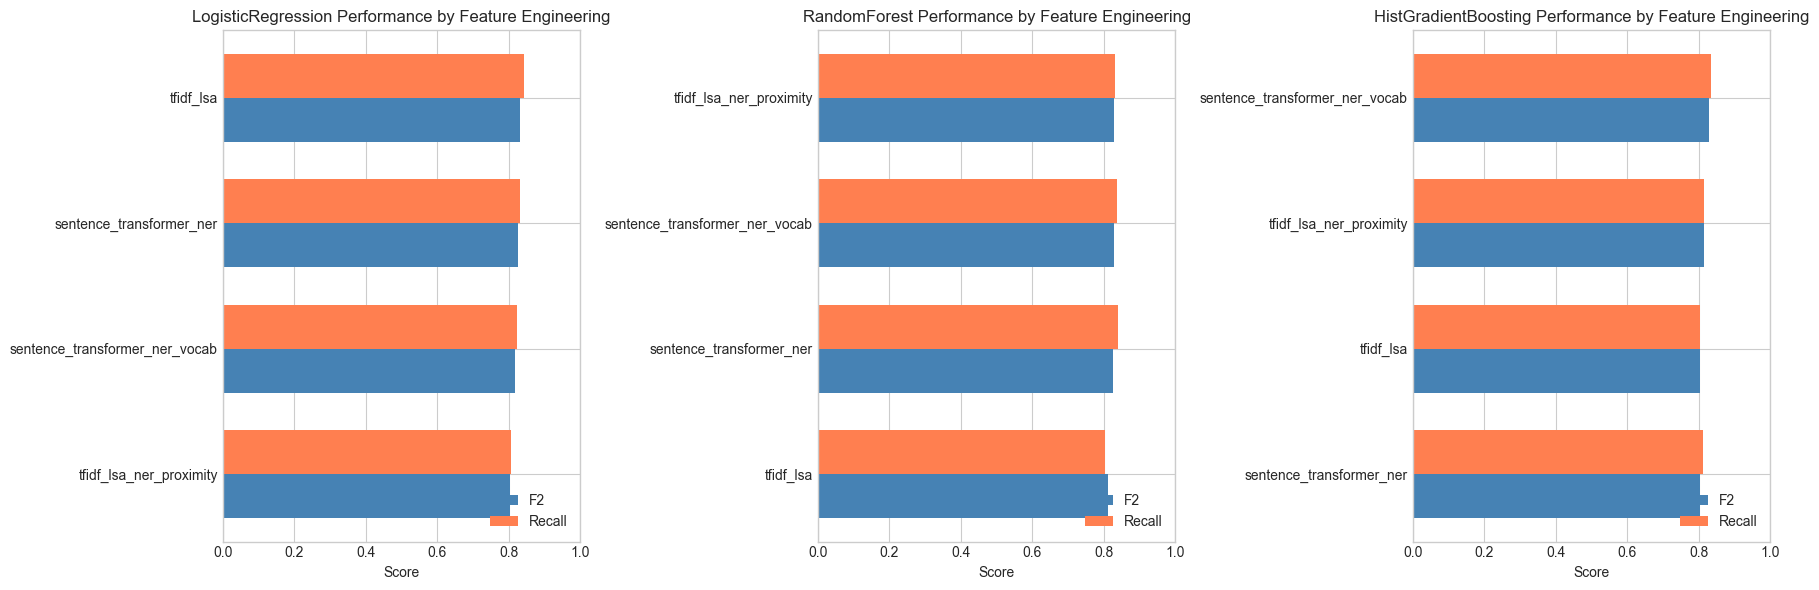

In [19]:
# Visualize comparison - show both classifiers side by side
plot_fe_comparison(fe_df, save_path=MODELS_DIR / 'ep_fe_comparison.png')

## 5.1 Feature Transformer Hyperparameter Tuning

Based on the comparison results above, we tune the key hyperparameter for the best-performing feature engineering method.

TUNING LSA_N_COMPONENTS FOR tfidf_lsa

Testing values: [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400]
Classifier: LogisticRegression (baseline)
Transformer fitted on: TRAINING data only (563 samples)
CV evaluated on: TRAIN+VAL combined (751 samples)
CV: 3-fold stratified

Testing lsa_n_components=50...
  CV F2: 0.8347 (+/- 0.0195)
Testing lsa_n_components=60...
  CV F2: 0.8312 (+/- 0.0202)
Testing lsa_n_components=70...
  CV F2: 0.8323 (+/- 0.0263)
Testing lsa_n_components=80...
  CV F2: 0.8359 (+/- 0.0125)
Testing lsa_n_components=90...
  CV F2: 0.8308 (+/- 0.0208)
Testing lsa_n_components=100...
  CV F2: 0.8323 (+/- 0.0225)
Testing lsa_n_components=120...
  CV F2: 0.8291 (+/- 0.0289)
Testing lsa_n_components=150...
  CV F2: 0.8288 (+/- 0.0236)
Testing lsa_n_components=200...
  CV F2: 0.8287 (+/- 0.0286)
Testing lsa_n_components=250...
  CV F2: 0.8265 (+/- 0.0217)
Testing lsa_n_components=300...
  CV F2: 0.8412 (+/- 0.0225)
Testing lsa_n_components=400...
  CV F2: 0.8322 (+/-

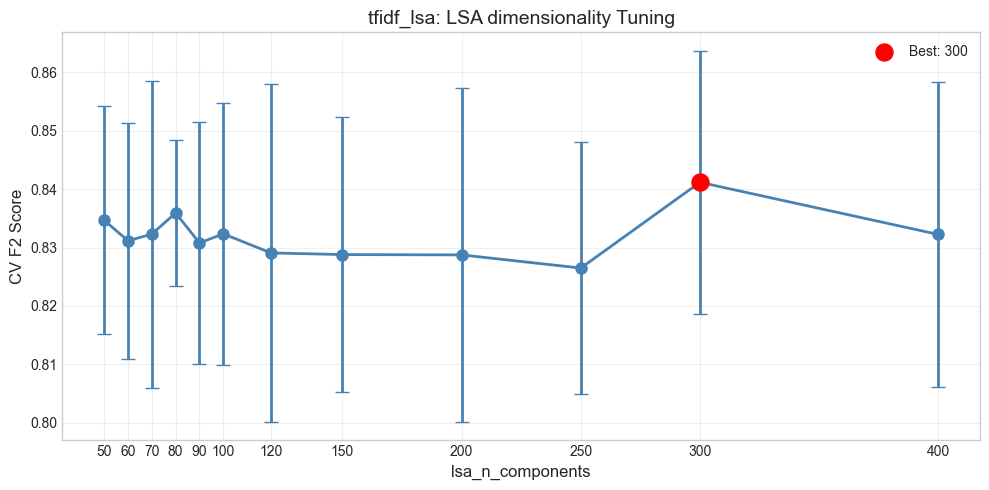

In [20]:
# Choose the baseline classifier to use based on best performing combination
baseline_clf = classifiers[best_clf]['model']

# Check if tuning configuration exists for the best method
if best_fe in TUNING_CONFIGS:
    tuning_config = TUNING_CONFIGS[best_fe]
    param_name = tuning_config['param_name']
    param_values = tuning_config['param_values']
    description = tuning_config['description']
    
    print("=" * 70)
    print(f"TUNING {param_name.upper()} FOR {best_fe}")
    print("=" * 70)
    print(f"\nTesting values: {param_values}")
    print(f"Classifier: {best_clf} (baseline)")
    print(f"Transformer fitted on: TRAINING data only ({len(X_train)} samples)")
    print(f"CV evaluated on: TRAIN+VAL combined ({len(X_trainval)} samples)")
    print(f"CV: {N_FOLDS}-fold stratified\n")
    
    # Tune transformer: fit on training data, evaluate on train+val
    tuning_df = tune_feature_transformer(
        transformer_class=EPFeatureTransformer,
        base_config=fe_configs[best_fe],
        param_name=param_name,
        param_values=param_values,
        X_fe=X_train,
        classifier=baseline_clf,
        cv=cv,
        X_cv=X_trainval,
        y_cv=y_trainval,
        scorer=f2_scorer,
        random_state=RANDOM_STATE,
    )
    
    print("\n" + "=" * 70)
    
    # Analyze tuning results and select best hyperparameter value
    if tuning_df is not None:
        default_value = fe_configs[best_fe].get(param_name)
        
        optimal_param_value, best_tuned_f2 = analyze_tuning_results(
            tuning_df=tuning_df,
            param_name=param_name,
            default_value=default_value,
        )
        
        # Plot the tuning results
        plot_tuning_results(
            tuning_df=tuning_df,
            param_name=param_name,
            param_values=param_values,
            optimal_param_value=optimal_param_value,
            method_name=best_fe,
            description=description,
            save_path=IMAGES_DIR / f'ep_tuning_{best_fe}.png',
        )
    else:
        optimal_param_value = None
else:
    print(f"No tuning configuration defined for {best_fe}")
    print("No tuning was performed.")
    tuning_df = None
    optimal_param_value = None

## 6. Pipeline Export

Create and export the best feature transformer for use in the model selection notebook.

In [21]:
# Create the best transformer with optimal hyperparameters from tuning
print(f"Selected feature engineering approach: {best_fe}")
print(f"Base configuration: {fe_configs[best_fe]}")

# Create final config with optimal hyperparameters
final_config = fe_configs[best_fe].copy()
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    final_config[param_name] = optimal_param_value
    print(f"Optimal {param_name}: {optimal_param_value}")

# Create transformer with best configuration
final_transformer = EPFeatureTransformer(**final_config, random_state=RANDOM_STATE)

# Fit on training data
X_train_final = final_transformer.fit_transform(X_train)
print(f"\nFinal feature shape: {X_train_final.shape}")

# Verify by transforming validation data
X_val_final = final_transformer.transform(X_val)
print(f"Validation feature shape: {X_val_final.shape}")

Selected feature engineering approach: tfidf_lsa
Base configuration: {'method': 'tfidf_lsa', 'max_features': 10000, 'lsa_n_components': 100, 'include_metadata_features': False}
Optimal lsa_n_components: 300

Final feature shape: (563, 300)
Validation feature shape: (188, 300)


In [22]:
# Save the fitted transformer
transformer_path = MODELS_DIR / 'ep_feature_transformer.joblib'
joblib.dump(final_transformer, transformer_path)
print(f"Transformer saved to: {transformer_path}")

# Save configuration for reproducibility
config_path = MODELS_DIR / 'ep_feature_config.json'
final_transformer.save_config(config_path)
print(f"Configuration saved to: {config_path}")

# Also save the comparison results
results_path = MODELS_DIR / 'ep_fe_comparison.json'
with open(results_path, 'w') as f:
    json.dump(fe_results, f, indent=2)
print(f"Comparison results saved to: {results_path}")

Transformer saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_transformer.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_config.json
Comparison results saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_fe_comparison.json


## 7. Summary

In [23]:
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} articles")
print(f"  - Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  - Train+Val (used for CV): {len(X_trainval)} ({len(X_trainval)/len(df)*100:.1f}%)")
print(f"\nClass distribution (training):")
print(f"  - Has ESG: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  - No ESG: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")

# Report best results - use tuned values if tuning was performed
print(f"\nBest Feature Engineering: {best_fe}")
print(f"  - Best Classifier: {best_clf}")

# Use tuned score and feature count if tuning was done, otherwise use baseline
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    print(f"  - CV F2 Score: {best_tuned_f2:.4f} (after tuning)")
    print(f"  - Features: {X_train_final.shape[1]}")
    print(f"  - Optimal {param_name}: {optimal_param_value}")
else:
    print(f"  - CV F2 Score: {best_row['cv_f2']:.4f}")
    print(f"  - Features: {int(best_row['n_features'])}")

print(f"\nArtifacts saved:")
print(f"  - {MODELS_DIR / 'ep_feature_transformer.joblib'}")
print(f"  - {MODELS_DIR / 'ep_feature_config.json'}")
print(f"  - {MODELS_DIR / 'ep_fe_comparison.json'}")
print(f"\nNext: Run ep2_model_selection_tuning.ipynb for model selection and hyperparameter tuning")
print("=" * 60)

NOTEBOOK SUMMARY

Dataset: 939 articles
  - Training: 563 (60.0%)
  - Validation: 188 (20.0%)
  - Train+Val (used for CV): 751 (80.0%)

Class distribution (training):
  - Has ESG: 318 (56.5%)
  - No ESG: 245 (43.5%)

Best Feature Engineering: tfidf_lsa
  - Best Classifier: LogisticRegression
  - CV F2 Score: 0.8412 (after tuning)
  - Features: 300
  - Optimal lsa_n_components: 300

Artifacts saved:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_transformer.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_config.json
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_fe_comparison.json

Next: Run ep2_model_selection_tuning.ipynb for model selection and hyperparameter tuning
